# Install Packages

In [1]:
!pip install evaluate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.3.3.83 which is incompatible.
torch 2.5.1+cu124 requires 

# Import Libraries

In [2]:
import evaluate
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
from datasets import Dataset, DatasetDict, ClassLabel
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

2025-04-30 06:36:55.709994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745995016.040302      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745995016.117058      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Set Device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Config

In [4]:
MODEL_NAME = "microsoft/deberta-v3-base"
MAX_LENGTH = 512
NUM_LABELS = 8
TEST_SIZE = 0.1
VALID_SIZE = 0.1
LEARNING_RATE = 2e-5
BATCH_SIZE = 8
EPOCHS = 10
OUTPUT_DIR = "./math_classifier_results"
LOGGING_DIR = "./math_classifier_logs"

# Load Data

In [5]:
df = pd.read_csv("/kaggle/input/classification-of-math-problems-by-kasut-academy/train.csv")
new_data = pd.read_csv("/kaggle/input/math-problem-classification-data/train_augmented.csv")
df = pd.concat([df, new_data]).reset_index(drop=True).sample(frac=1).reset_index(drop=True)

print(f"Loaded DataFrame shape: {df.shape}")
print("Label distribution:\n", df['label'].value_counts())

Loaded DataFrame shape: (21598, 2)
Label distribution:
 label
0    2995
5    2969
1    2952
4    2836
6    2755
3    2734
2    2637
7    1720
Name: count, dtype: int64


# Data Preprocessing

In [6]:
def clean_math_text_final(text):
    
    text = str(text)
    text = re.sub(r'^\s*\d+\.\s*', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'#\w+', ' ', text)
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r' ', text)
    text = re.sub(r'\s+', ' ', text).strip().lower()

    return text

print("\n--- Applying Text Cleaning ---")
df['cleaned_question'] = df['Question'].apply(clean_math_text_final)
print("Cleaning done.")


--- Applying Text Cleaning ---
Cleaning done.


# Prepare Data for Training

In [7]:
print("\n--- Creating Dataset & Casting Label Type ---")
dataset = Dataset.from_pandas(df)

class_label_feature = ClassLabel(num_classes=NUM_LABELS)
dataset = dataset.cast_column('label', class_label_feature)

print(f"Dataset features after casting 'label' column:")
print(dataset.features)

print("\n--- Splitting Dataset ---")
train_test_split = dataset.train_test_split(test_size=TEST_SIZE, stratify_by_column='label')
train_valid_split = train_test_split['train'].train_test_split(test_size=VALID_SIZE / (1 - TEST_SIZE), stratify_by_column='label')

final_datasets = DatasetDict({
    'train': train_valid_split['train'],
    'validation': train_valid_split['test'],
    'test': train_test_split['test']
})
print("Dataset splits created:")
print(final_datasets)


--- Creating Dataset & Casting Label Type ---


Casting the dataset:   0%|          | 0/21598 [00:00<?, ? examples/s]

Dataset features after casting 'label' column:
{'Question': Value(dtype='string', id=None), 'label': ClassLabel(names=['0', '1', '2', '3', '4', '5', '6', '7'], id=None), 'cleaned_question': Value(dtype='string', id=None)}

--- Splitting Dataset ---
Dataset splits created:
DatasetDict({
    train: Dataset({
        features: ['Question', 'label', 'cleaned_question'],
        num_rows: 17278
    })
    validation: Dataset({
        features: ['Question', 'label', 'cleaned_question'],
        num_rows: 2160
    })
    test: Dataset({
        features: ['Question', 'label', 'cleaned_question'],
        num_rows: 2160
    })
})


# Tokenization

In [8]:
print("\n--- Tokenization ---")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    
    return tokenizer(examples["cleaned_question"],
                     padding="max_length",
                     truncation=True,
                     max_length=MAX_LENGTH)

tokenized_datasets = final_datasets.map(tokenize_function, batched=True)


tokenized_datasets = tokenized_datasets.remove_columns(["Question", "cleaned_question"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
print("Tokenization complete.")
print("Example train sample:", tokenized_datasets["train"][0])


--- Tokenization ---


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/17278 [00:00<?, ? examples/s]

Map:   0%|          | 0/2160 [00:00<?, ? examples/s]

Map:   0%|          | 0/2160 [00:00<?, ? examples/s]

Tokenization complete.
Example train sample: {'labels': tensor(6), 'input_ids': tensor([    1,   744,   262, 20009,  9459,   294,   647,   435,   392,   404,
         1540,   525,   592,   647,   445,   453,   525,  1540,   621,   592,
          647,   508,   525,   712,  1540,   940,   592,   339,   295,   282,
         5988,   314,   262,   492,   265, 13280,   278,  3329,   302,   287,
          452,   285,   278,   303,   266,   988,  1327,   287,  1285,   285,
          278,   303,   363,  1327,   287,  1207,   285,   278,   303, 25760,
          386,  1527,   287,   407,   285,   278,   269, 14833,   287,   473,
          285,   298,   618,   439,   264,  2003,     2,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0

# Define Evaluation Metrics

In [9]:
print("\n--- Setting up Metrics ---")
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    f1_weighted = f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    f1_micro = f1_metric.compute(predictions=predictions, references=labels, average="micro")["f1"]
    return {"accuracy": accuracy, "f1_weighted": f1_weighted, "f1_micro": f1_micro}


--- Setting up Metrics ---


# Load and Train deberta-v3 model with Trainer

In [10]:
print("\n--- Loading Model ---")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS
)

model.to(device)
print(f"Model '{MODEL_NAME}' loaded for {NUM_LABELS}-class classification.")


print("\n--- Defining Training Arguments ---")
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir=LOGGING_DIR,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    greater_is_better=True,
    push_to_hub=False,
    report_to="none",
    fp16=True,
    save_total_limit=3
)

print("\n--- Initializing Trainer ---")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


print("\n--- Starting Fine-Tuning ---")
train_result = trainer.train()


trainer.log_metrics("train", train_result.metrics)
trainer.save_metrics("train", train_result.metrics)
trainer.save_state()


trainer.save_model(OUTPUT_DIR + "/best_model")
print("Training finished. Best model saved.")


print("\n--- Evaluating on Test Set ---")
test_results = trainer.evaluate(eval_dataset=tokenized_datasets["test"])

print("Test Set Evaluation Results:")
print(test_results)
trainer.log_metrics("eval", test_results)
trainer.save_metrics("eval", test_results)


--- Loading Model ---


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model 'microsoft/deberta-v3-base' loaded for 8-class classification.

--- Defining Training Arguments ---

--- Initializing Trainer ---

--- Starting Fine-Tuning ---


/tmp/ipykernel_19/3302889195.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Micro
1,0.642000,0.400164,0.881019,0.879396,0.881019
2,0.327500,0.315572,0.900926,0.901592,0.900926
3,0.254800,0.435399,0.898611,0.899081,0.898611
4,0.220600,0.519708,0.914352,0.914284,0.914352
5,0.330500,1.109834,0.906481,0.905982,0.906481
6,0.288600,1.189082,0.914352,0.914054,0.914352
7,0.212600,1.316925,0.912963,0.913250,0.912963
8,0.161000,1.386457,0.915278,0.915297,0.915278
9,0.113600,1.381452,0.915278,0.915500,0.915278
10,0.088200,1.408735,0.916204,0.916246,0.916204


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

***** train metrics *****
  epoch                    =       10.0
  total_flos               = 42341269GF
  train_loss               =     0.2639
  train_runtime            = 3:59:11.73
  train_samples_per_second =     12.039
  train_steps_per_second   =      0.753
Training finished. Best model saved.

--- Evaluating on Test Set ---


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test Set Evaluation Results:
{'eval_loss': 1.339593529701233, 'eval_accuracy': 0.9212962962962963, 'eval_f1_weighted': 0.9210735102888221, 'eval_f1_micro': 0.9212962962962963, 'eval_runtime': 62.8988, 'eval_samples_per_second': 34.341, 'eval_steps_per_second': 2.146, 'epoch': 10.0}
***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =     0.9213
  eval_f1_micro           =     0.9213
  eval_f1_weighted        =     0.9211
  eval_loss               =     1.3396
  eval_runtime            = 0:01:02.89
  eval_samples_per_second =     34.341
  eval_steps_per_second   =      2.146


# Plot Training Curves


--- Plotting Training Curves vs. Steps ---

Found 10 logs with training loss.
Found 11 logs with evaluation metrics.


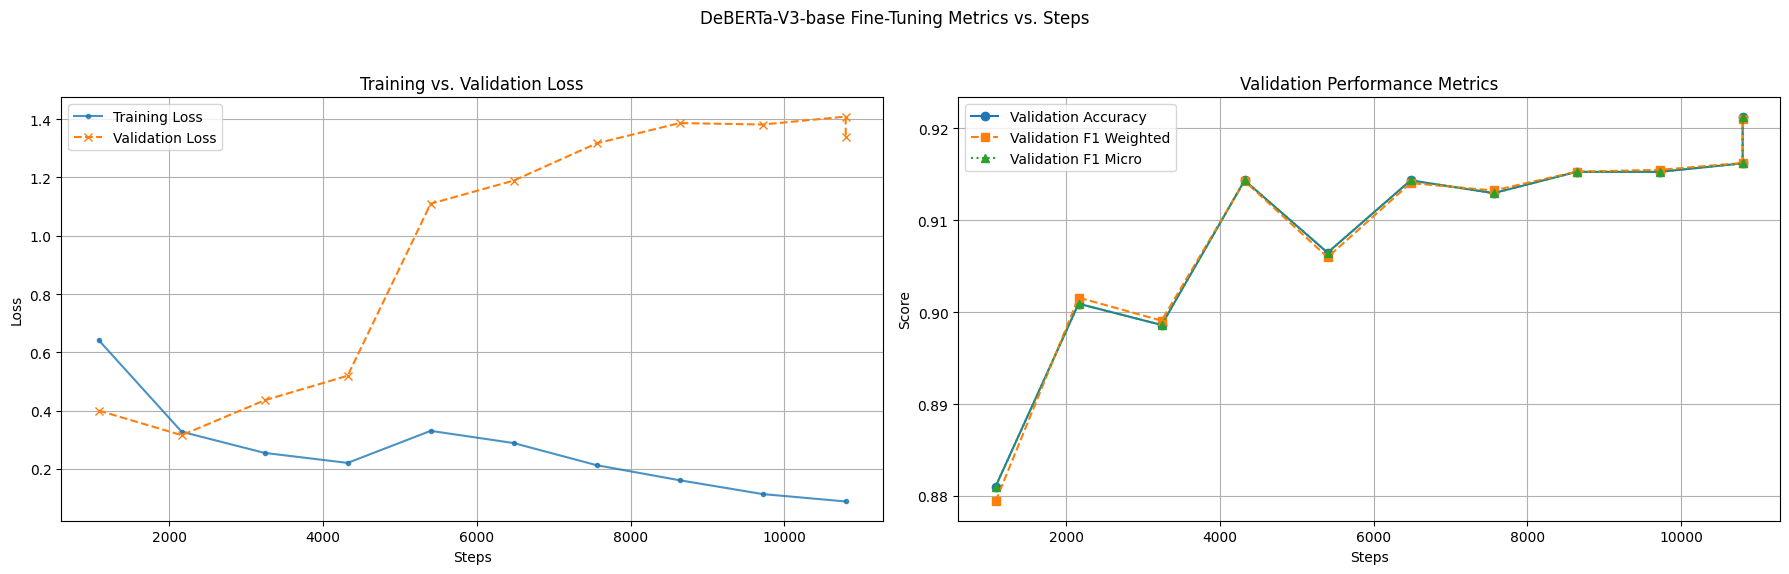

In [11]:
print("\n--- Plotting Training Curves vs. Steps ---")

# Access the log history
log_history = trainer.state.log_history
log_df = pd.DataFrame(log_history)

# --- Filtering for Step Plots ---
# Get all logs that contain a training loss value
training_loss_logs = log_df[log_df['loss'].notna()].reset_index()
# Get all logs that contain evaluation metrics
eval_logs = log_df[log_df['eval_loss'].notna()].reset_index()

print(f"\nFound {len(training_loss_logs)} logs with training loss.")
print(f"Found {len(eval_logs)} logs with evaluation metrics.")

if training_loss_logs.empty:
    print("Warning: No logs found containing training loss ('loss' key). Cannot plot training loss.")
if eval_logs.empty:
    print("Warning: No logs found containing evaluation metrics ('eval_loss' key). Cannot plot validation metrics.")


# --- Plotting vs Steps ---

plt.figure(figsize=(18, 6))

# Plot 1: Training and Validation Loss vs Steps
plt.subplot(1, 2, 1)
if not training_loss_logs.empty:
    plt.plot(training_loss_logs['step'], training_loss_logs['loss'], label='Training Loss', marker='.', linestyle='-', alpha=0.8)
else:
    # Add text placeholder if no data
     plt.text(0.5, 0.5, 'Training Loss data not found in logs', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

if not eval_logs.empty:
    plt.plot(eval_logs['step'], eval_logs['eval_loss'], label='Validation Loss', marker='x', linestyle='--')
else:
     if training_loss_logs.empty:
          plt.text(0.5, 0.4, 'Validation Loss data not found in logs', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)


plt.title('Training vs. Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Validation Accuracy & F1 Scores vs Steps
plt.subplot(1, 2, 2)
if not eval_logs.empty:
    plt.plot(eval_logs['step'], eval_logs['eval_accuracy'], label='Validation Accuracy', marker='o', linestyle='-')
    plt.plot(eval_logs['step'], eval_logs['eval_f1_weighted'], label='Validation F1 Weighted', marker='s', linestyle='--')
    plt.plot(eval_logs['step'], eval_logs['eval_f1_micro'], label='Validation F1 Micro', marker='^', linestyle=':')
    plt.title('Validation Performance Metrics')
    plt.xlabel('Steps')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
else:
     plt.text(0.5, 0.5, 'Validation Performance data not found in logs', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)


plt.suptitle('DeBERTa-V3-base Fine-Tuning Metrics vs. Steps')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Run predictions on Test set and Submit

In [12]:
print("\n--- Preparing Competition Test Set ---")

comp_test_df = pd.read_csv("/kaggle/input/classification-of-math-problems-by-kasut-academy/test.csv")
print(f"Loaded competition test data shape: {comp_test_df.shape}")

print("Cleaning competition test data...")
comp_test_df['cleaned_question'] = comp_test_df['Question'].apply(clean_math_text_final)
print("Cleaning complete.")

predict_dataset = Dataset.from_pandas(comp_test_df[['cleaned_question']])
print("Competition test data converted to Dataset format.")
print(predict_dataset)

def tokenize_for_predict(examples):
    return tokenizer(examples["cleaned_question"],
                     padding="max_length",
                     truncation=True,
                     max_length=MAX_LENGTH)

print("\n--- Tokenizing Competition Test Set ---")
tokenized_predict_dataset = predict_dataset.map(tokenize_for_predict, batched=True)

tokenized_predict_dataset = tokenized_predict_dataset.remove_columns(["cleaned_question"])
tokenized_predict_dataset.set_format("torch")
print("Tokenization complete.")
print("Example prediction sample:", tokenized_predict_dataset[0])


print("\n--- Making Predictions ---")
predictions_output = trainer.predict(tokenized_predict_dataset)

logits = predictions_output.predictions

predicted_labels = np.argmax(logits, axis=-1)
print("Predictions generated.")
print("Example predicted labels:", predicted_labels[:10])

print("\n--- Creating Submission File ---")
submission_df = pd.DataFrame({
    'id': comp_test_df['id'],
    'label': predicted_labels
})

submission_filename = 'submission.csv'
submission_df.to_csv(submission_filename, index=False)
print(f"Submission file '{submission_filename}' created successfully.")
print(submission_df.head())


--- Preparing Competition Test Set ---
Loaded competition test data shape: (3044, 2)
Cleaning competition test data...
Cleaning complete.
Competition test data converted to Dataset format.
Dataset({
    features: ['cleaned_question'],
    num_rows: 3044
})

--- Tokenizing Competition Test Set ---


Map:   0%|          | 0/3044 [00:00<?, ? examples/s]

Tokenization complete.
Example prediction sample: {'input_ids': tensor([    1,  2165,   280, 51945,   767,  1842,   341,   667,   341, 10015,
         1225,   667,   341,   706,  8454,  1225,   667,   341,  4604, 17334,
          270,   584,   260,  2620,   673,   280,     2,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
